# Problem 2

## Agenda
- Problem Description
- Problem Implementation
- Alternative Problems
- Wrap-Up

## Problem Description
- <b>Consider a grid of N buses to which generators and loads are connected, and discover a grid loss function based on M per-bus power injection readings and the corresponding M total grid loss measurements.<b>

    _______________________________________________________________________________________________________________________

Considered "Kite" 5 Bus Network

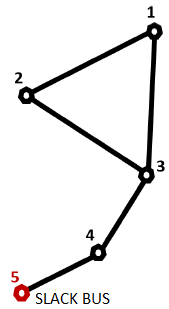

- <b>Implementation.<b>

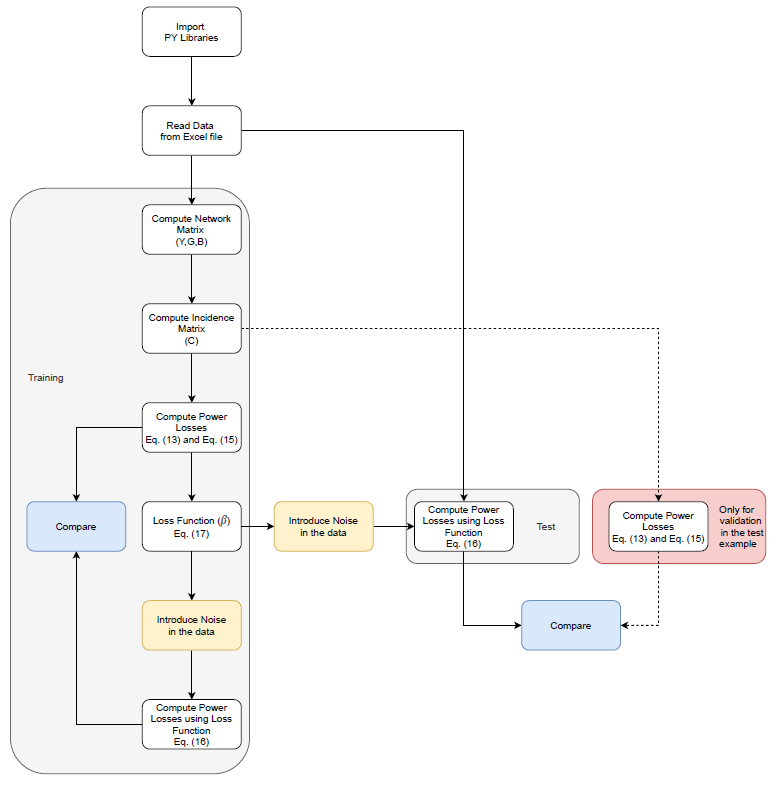

<b>Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt


<b>Parameters

In [2]:
noiseFactor=0.0025     #noise
networkFactor=100      #to change the characteristics of the network (Y)
PtestFactor=3          #to obtain losses similar to the training data; OLD VALUE: 3

## <b>Import data (From Excel file)

In [3]:
Info = np.array(pd.read_excel (r"dataC2.xlsx", sheet_name='Info', header=None))
# Information about the slack bus
SlackBus=Info[0,1]
print ("Slack Bus: ", SlackBus,"\n")

# Network Information
Net_Info = np.array(pd.read_excel (r"dataC2.xlsx", sheet_name='Y_Data'))
print ("Lines information (Admitances)\n", Net_Info, "\n")

#Power Information (train)
Power_Info = np.array(pd.read_excel (r"dataC2.xlsx", sheet_name='Load(t,Bus)'))
print("Power info shape: ",Power_Info.shape)
Power_Info = np.delete(Power_Info,[0],1) # for some reason, the slack bus is not included in the data
print ("Power consumption information (time, Bus) - (Train)\n", Power_Info, "\n")

#Power Information (test)
Power_Test = np.array(pd.read_excel (r"dataC2.xlsx", sheet_name='Test_Load(t,Bus)'))
Power_Test = np.delete(Power_Test,[0],1)
print ("Power consumption information (time, Bus) - (Test)\n", Power_Test)

time=Power_Info.shape[0]
P=Power_Info
Ptest=Power_Test *PtestFactor

Slack Bus:  5 

Lines information (Admitances)
 [[1 2 '0,01-0,1i']
 [1 3 '0,02-0,2i']
 [2 3 '0,03-0,2i']
 [3 4 '0,03-0,2i']
 [4 5 '0,02-0,2i']] 

Power info shape:  (13, 5)
Power consumption information (time, Bus) - (Train)
 [[0.332 0.064 0.084 0.12 ]
 [0.236 0.164 0.276 0.064]
 [0.224 0.708 1.572 0.072]
 [0.36  3.44  1.188 0.18 ]
 [1.332 2.176 0.484 1.464]
 [1.516 3.02  0.316 0.624]
 [0.92  0.916 0.404 2.772]
 [0.752 0.64  0.396 1.464]
 [1.828 0.684 0.576 0.576]
 [3.568 0.564 0.828 0.428]
 [0.78  0.356 0.728 0.348]
 [0.856 0.22  0.308 0.12 ]
 [0.684 0.528 0.256 0.44 ]] 

Power consumption information (time, Bus) - (Test)
 [[0.18  0.06  0.188 0.132]
 [0.1   0.06  0.992 0.132]
 [0.388 0.1   1.576 0.132]
 [0.28  0.196 0.08  1.94 ]
 [0.5   0.184 0.064 0.572]
 [1.16  0.108 0.064 0.188]
 [1.036 0.06  0.068 0.08 ]
 [1.036 0.064 0.112 0.064]
 [1.768 0.064 0.2   0.068]
 [0.804 0.092 0.184 0.064]
 [0.824 0.196 0.088 0.096]
 [0.52  0.188 0.064 0.196]
 [0.184 0.104 0.068 0.192]]


### <b>Admittance Matrix(Y); Conductance Matrix(G); Susceptance Matrix(B)

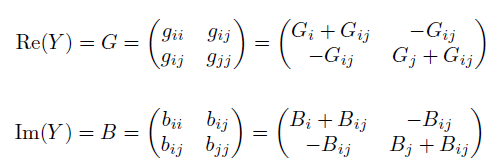

In [4]:
# Determine the number of Bus
nBus=max(np.max(Net_Info[:,0]),np.max(Net_Info[:,1]))

# Create the variable number of lines and the admitance matrix (Y)
nLines=Net_Info.shape[0]

Y=np.zeros((nBus,nBus), dtype=complex)

#Complete the Y matrix and update the number of lines
for i in range (Net_Info.shape[0]):
    y_aux=Net_Info[i,2].replace(",",".")
    y_aux=y_aux.replace("i","j")
    Y[Net_Info[i,0]-1,Net_Info[i,0]-1]=Y[Net_Info[i,0]-1,Net_Info[i,0]-1]+complex(y_aux)*networkFactor
    Y[Net_Info[i,1]-1,Net_Info[i,1]-1]=Y[Net_Info[i,1]-1,Net_Info[i,1]-1]+complex(y_aux)*networkFactor
    Y[Net_Info[i,0]-1,Net_Info[i,1]-1]=Y[Net_Info[i,0]-1,Net_Info[i,1]-1]-complex(y_aux)*networkFactor
    Y[Net_Info[i,1]-1,Net_Info[i,0]-1]=Y[Net_Info[i,1]-1,Net_Info[i,0]-1]-complex(y_aux)*networkFactor

            
# Remove the slack bus from the admitance matrix            
Yl=np.delete(Y, np.s_[SlackBus-1], axis=0)
Yl=np.delete(Yl, np.s_[SlackBus-1], axis=1)

# Conductance Matrix
G=Yl.real

# Susceptance Matrix
B=Yl.imag
print("The admitance matrix Y is:\n", Y, "\n")
print("The conductance matrix G is\n", G, "\n")
print("The susceptance matrix B is\n",B, "\n")


The admitance matrix Y is:
 [[ 3.-30.j -1.+10.j -2.+20.j  0. +0.j  0. +0.j]
 [-1.+10.j  4.-30.j -3.+20.j  0. +0.j  0. +0.j]
 [-2.+20.j -3.+20.j  8.-60.j -3.+20.j  0. +0.j]
 [ 0. +0.j  0. +0.j -3.+20.j  5.-40.j -2.+20.j]
 [ 0. +0.j  0. +0.j  0. +0.j -2.+20.j  2.-20.j]] 

The conductance matrix G is
 [[ 3. -1. -2.  0.]
 [-1.  4. -3.  0.]
 [-2. -3.  8. -3.]
 [ 0.  0. -3.  5.]] 

The susceptance matrix B is
 [[-30.  10.  20.   0.]
 [ 10. -30.  20.   0.]
 [ 20.  20. -60.  20.]
 [  0.   0.  20. -40.]] 



### <b>Incidence Matrix (Bus,Lines)

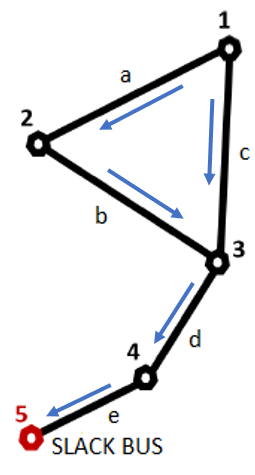

In [5]:
# Create the vectors
C=np.zeros((nBus,nLines))
nLine_Aux=0

# Determine the Incidence Matrix
for i in range (Y.shape[0]):
    for j in range (i+1,Y.shape[1]):
        if np.absolute(Y[i,j])!=0:
            C[i,nLine_Aux]=1
            C[j,nLine_Aux]=-1
            nLine_Aux=nLine_Aux+1           

# Remove the slack bus from the matrix
Cl=np.delete(C, np.s_[SlackBus-1], axis=0)

print ("The incidence matrix C (nBus,nLines) is:\n",Cl)

The incidence matrix C (nBus,nLines) is:
 [[ 1.  1.  0.  0.  0.]
 [-1.  0.  1.  0.  0.]
 [ 0. -1. -1.  1.  0.]
 [ 0.  0.  0. -1.  1.]]


### <b>Definition of Matrix Gij (Diagonal and vector)

In [6]:
# Create the vectors
# in automatized manner

def get_Gv_Gd(Y,nLines):
    Gv=np.zeros((1,nLines))
    Gd=np.zeros((nLines,nLines))
    nLine_Aux=0
    for i in range (Y.shape[0]):
        for j in range (i+1,Y.shape[1]):
            if np.absolute(Y[i,j])!=0:
                Gv[0,nLine_Aux]=-np.real(Y[i,j])          #Information about the lines condutance [Vector]
                Gd[nLine_Aux,nLine_Aux]=-np.real(Y[i,j])  #Information about the lines condutance [Diagonal in matrix]
                nLine_Aux=nLine_Aux+1
    return Gv, Gd

Gv, Gd = get_Gv_Gd(Y,nLines)

print ("Gij_Diag:\n",Gd)


Gij_Diag:
 [[1. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 3. 0. 0.]
 [0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 2.]]


### <b>Definition of the Power Losses in two different ways, following equations (13) and (15) of lectures.

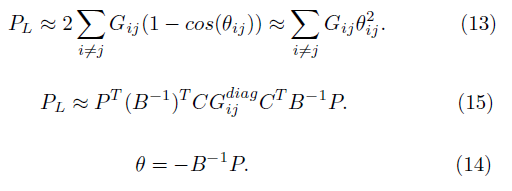

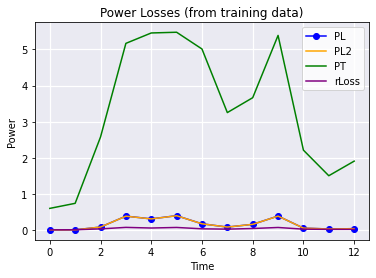

In [7]:
# Matrix creation
# in automatized manner

def getLosses(P,B,Cl,Gd,time,nLines):
    '''
    This function returns
    PL: Power Losses using equation (15)
    PL2: Power Losses using equation (13)
    PT: Total Power
    rLoss: Power Losses (%)
    '''

    teta=np.zeros((nBus-1,time))
    grau=np.zeros((nLines,time))
    PL=np.zeros((time))
    PL2=np.zeros((time))
    PT=np.zeros((time))
    rLoss=np.zeros((time))

    alfa=np.dot(np.dot(np.dot(np.dot(np.linalg.inv(B),Cl),Gd),np.transpose(Cl)),np.linalg.inv(B))  #Used in Equation (15)

    for m in range (time):
        PL[m]=np.dot(P[m,:],np.dot(alfa,np.transpose(P[m,:])))  #Power Losses using equation (15)
        
        teta[:,m]=np.dot(np.linalg.inv(B),np.transpose(P[m,:])) #Voltage angle (Teta). Equation (14) 
    
        grau[:,m]=np.dot(np.transpose(Cl),teta[:,m])            #Voltage angle difference (Teta ij)
    
        PL2[m]=np.dot(2*Gv,1-np.cos(grau[:,m]))                 #Power Losses using equation (13)
    
        PT[m]=np.sum([P[m,:]])                                  #Total Power   
    
        rLoss[m]=np.divide(PL2[m],PT[m])                        #Power Losses (%)
    return PL, PL2, PT, rLoss


# obtaining the training data
PL, PL2, PT, rLoss = getLosses(P,B,Cl,Gd,time,nLines)

# obtaining the test data
PLtest, PL2test, PTtest, rLosstest = getLosses(Ptest,B,Cl,Gd,time,nLines)


# some prints
#print ("Total Power consumption:\n",PT ,"\n")    
#print ("Power Losses obtained using the Theta:\n",PL2 ,"\n")  
#print ("Power Losses obtained without using the Theta:\n",PL ,"\n")  

# plotting these losses
def plotLosses(time,PL,PL2,PT,rLoss):
    # use fig, ax instead of plt
    fig, ax = plt.subplots()
    ax.plot(time,PL,'o-',color='blue',label='PL')
    ax.plot(time,PL2,'-',color='orange',label='PL2')
    ax.plot(time,PT,'-',color='green',label='PT')
    ax.plot(time,rLoss,'-',color='purple',label='rLoss')
    ax.legend()
    ax.set_xlabel('Time')
    ax.set_ylabel('Power')
    ax.set_title('Power Losses (from training data)')
    # set background color
    ax.set_facecolor('#eaeaf2')
    # add white grid
    ax.grid(color='white', linestyle='-', linewidth=1.25)
    # don't know whether to use log scale or not
    #ax.set_yscale('log')
    plt.show()

# training data plot
plotLosses(range(time),PL,PL2,PT,rLoss)

# test data plot
#plotLosses(range(time),PLtest,PL2test,PTtest,rLosstest)

## <b> Discovering the loss function



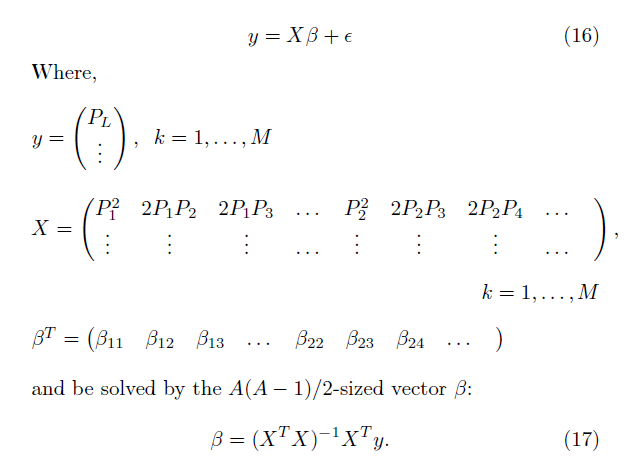

### defining matrix plot/form

In [8]:
def matrix_plot(matrix,prop):
    '''
    input: matrix to plot, proportion of matrix size to figure size
    output: plot of matrix with colorbar 
    '''
    fig_size = tuple([prop*i for i in matrix.shape]) 
    fig, ax = plt.subplots(figsize=fig_size)   
    im = ax.imshow(matrix)
    fig.colorbar(im, ticks=[matrix.min(), matrix.max()])
    plt.show() 

def matrix_form(matrix):
    # functions just like Mathematica's MatrixForm
    for i in range(matrix.shape[0]):
        print(matrix[i,:])
    

#matrix_plot(P,2)


### creating Y (i.e. PL) vector for regression

In [9]:
# Creating Y matrix (regarding regression)

# training data
Y1=PL  # equation 15
Y2=PL2 # equation 13

# test data
Y1test=PLtest  # equation 15
Y2test=PL2test # equation 13

### creating X matrix

In [10]:
# recall nBus = N
# recall time = k

# Creating X matrix
def create_X(P):
    N=P.shape[1]
    X = np.zeros((time,(N+1)*N//2))
    for i in range(time):
        pos=-1   # current position in the current row
        for j in range(N):
            pos+=1
            X[i,pos]=P[i,j]**2
            #print(pos," P(",i,",",j,")^2")
            for k in range(1,N-j):
                pos+=1
                X[i,pos] = 2*P[i,j]*P[i,k]
                #print(pos," 2P(",i,",",j,")P(",i,",",k,")")
    return X

# training data
X = create_X(P)

# test data
Xtest = create_X(Ptest)

#matrix_plot(X,1)

### some plots

P matrix:


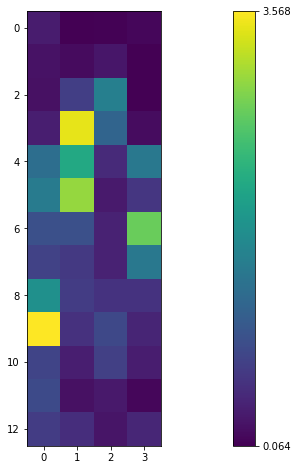

X^T X


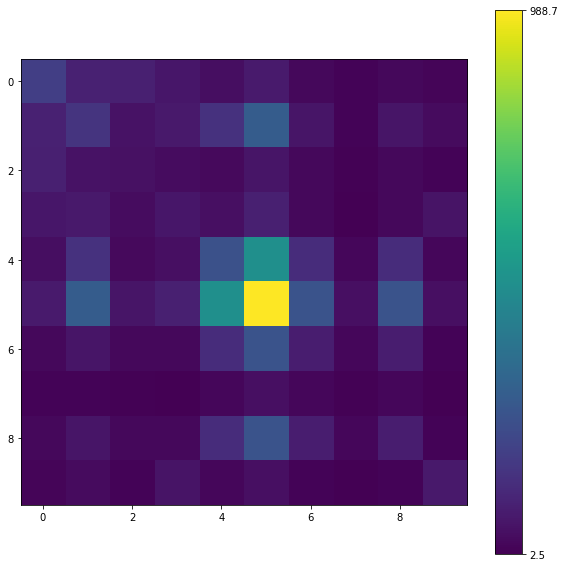

In [11]:
print("P matrix:")
#matrix_form(P)
matrix_plot(P,2)
print("X^T X")
#matrix_form(X.T@X)
matrix_plot(X.T@X,1)

### (ridge) regression

In [12]:
# hmm, for some reason X.T@X is linearly dependent
LA.det(X.T@X)

0.0

In [13]:
# passing noise to Y1 and Y2
def noisy(Y,noise):
    return Y+np.random.normal(0,noise,len(Y))


# applying (ridge) regression

def ridge_regression(X,Y,lamb):
    return LA.inv(X.T@X+lamb*np.identity(len(X.T@X)))@X.T@Y


def find_best_beta(X,Y1,Y2,noise_proportion):
    noise_sigma=(P.mean())*noise_proportion # noise standard deviation
    best_lamb=0.01  # presumed best regularization parameter
    error_list1=[]        
    error_list2=[]        
    for lamb in np.arange(0.01,1.,0.01): # regularization parameter
        # beta regression coefficients
        beta1=ridge_regression(X,noisy(Y1,noise_sigma),lamb)
        beta2=ridge_regression(X,noisy(Y2,noise_sigma),lamb)
        # predictions
        pred_Y1=X@beta1
        pred_Y2=X@beta2
        error1=[np.sum((pred_Y1-Y1)**2+(pred_Y1-Y2)**2)]
        error2=[np.sum((pred_Y2-Y1)**2+(pred_Y2-Y2)**2)]
        error_list1+=error1
        error_list2+=error2
        if error1==min(error_list1+error_list2):
            best_lamb,best_beta=lamb,beta1 
        if error2==min(error_list1,error_list2):
            best_lamb,best_beta=lamb,beta2
    return best_lamb,best_beta

# testing the best beta
best_lamb,best_beta=find_best_beta(X,Y1,Y2,1/20)



## Beta explainability
crudely, with less experiments

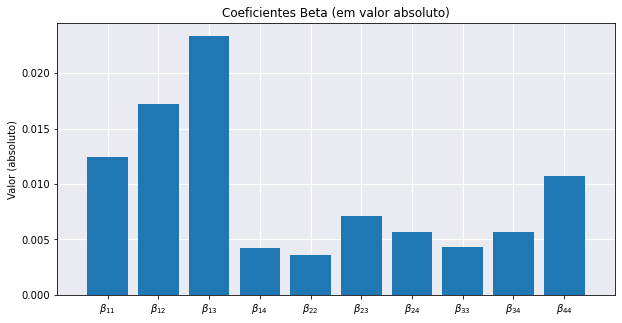

In [14]:

# plot beta coefficients
def plot_beta(beta, xAxisLegend):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(xAxisLegend,abs(beta))
    #ax.set_xlabel('Betas')
    ax.set_ylabel('Valor (absoluto)')
    ax.set_title('Coeficientes Beta (em valor absoluto)')
    # set background color
    ax.set_facecolor('#eaeaf2')
    # add white grid
    ax.grid(color='white', linestyle='-', linewidth=1.25)
    # adjust x axis length
    ax.set_xlim(-1,len(xAxisLegend))
    # make the grid completely transparent when on top of the bars
    ax.set_axisbelow(True)
    ax.grid(visible=True, color='white', linestyle='-', linewidth=1.25)
    plt.show()

xAxisLegend = [r'$\beta_{11}$',r'$\beta_{12}$',r'$\beta_{13}$',r'$\beta_{14}$',r'$\beta_{22}$',r'$\beta_{23}$',r'$\beta_{24}$',r'$\beta_{33}$',r'$\beta_{34}$',r'$\beta_{44}$']


plot_beta(best_beta,xAxisLegend)

### Iterating the experiment various times, for more reliable results

In [15]:
# Find convergence on Y - Mean of Beta values for graph convergence and small variation 

def find_mean_betas(X,Y1,Y2,noise_proportion,iterations):

    mean_best_betas = []    
    mean_best_lamb = []    
    
    for i in range(iterations):
        noise_sigma=(P.mean())*noise_proportion # noise standard deviation
        best_lamb=0.01  # presumed best regularization parameter
        error_list1=[]        
        error_list2=[]        
        for lamb in np.arange(0.01,1.,0.01): # regularization parameter

            # beta regression coefficients
            beta1=ridge_regression(X,noisy(Y1,noise_sigma),lamb)
            beta2=ridge_regression(X,noisy(Y2,noise_sigma),lamb)
            
            # predictions
            pred_Y1=X@beta1

            pred_Y2=X@beta2
            error1=[np.sum((pred_Y1-Y1)**2+(pred_Y1-Y2)**2)]
            error2=[np.sum((pred_Y2-Y1)**2+(pred_Y2-Y2)**2)]
            error_list1+=error1
            error_list2+=error2

            # Find best ones
            if error1==min(error_list1+error_list2):
                best_lamb,best_beta=lamb,beta1 
            if error2==min(error_list1,error_list2):
                best_lamb,best_beta=lamb,beta2

            mean_best_betas.append(best_beta)
            mean_best_lamb.append(best_lamb)

    
    # averaging out the best betas (loss function)
    if(len(mean_best_betas) > 0):
    
        mean_betas = [0]*len(mean_best_betas[0])

        for j in range(len(mean_best_betas[0])):
            for k in range(len(mean_best_betas)):
                mean_betas[j] = mean_betas[j] + mean_best_betas[k][j] 

        for j in range(len(mean_betas)):
            mean_betas[j] = mean_betas[j]/len(mean_best_betas)

        np_mean_betas = np.array(mean_betas)

    # averaging the best lambdas
    mean_val_lamb = sum(mean_best_lamb) / len(mean_best_lamb)


    return mean_val_lamb,np_mean_betas

# testing the best beta
iterations = 1000 # previously 10000
noise_proportion=1
mean_best_lamb , mean_best_beta = find_mean_betas(X,Y1,Y2,noise_proportion,iterations)

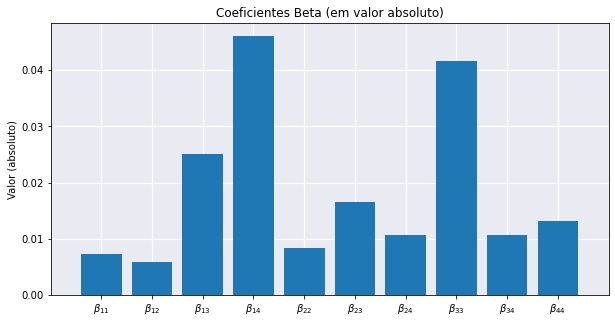

In [16]:
xAxisLegend=[r'$\beta_{11}$',r'$\beta_{12}$',r'$\beta_{13}$',r'$\beta_{14}$',r'$\beta_{22}$',r'$\beta_{23}$',r'$\beta_{24}$',r'$\beta_{33}$',r'$\beta_{34}$',r'$\beta_{44}$']
plot_beta(mean_best_beta,xAxisLegend)

## <b>Plot Results (Training)

### plot function

In [17]:
# plot function

def plot_predictions(Y1,Y2,pred_Y,mode,problem_type):
    # plot prediction and true values
    fig, ax = plt.subplots()
    ax.plot(range(time),Y1,'o-',color='blue',label='True Losses (eq 15)')
    ax.plot(range(time),Y2,'-',color='purple',label='True Losses (eq 13)')
    ax.plot(range(time),pred_Y,'-',color='orange',label='Predicted Losses')
    ax.legend()
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    ax.set_xlabel('Tempo')
    ax.set_ylabel('Potência')
    if problem_type=='original':
        if mode=='train':
            ax.set_title('problema original (resultados de treino)')
        if mode=='test':
            ax.set_title('problema original (resultados de teste)')
    if problem_type=='adjacency':
        if mode=='train':
            ax.set_title('adjacência (resultados de treino)')
        if mode=='test':
            ax.set_title('adjacência (resultados de teste)')
    if problem_type=='only accounting each bus':
        if mode=='train':
            ax.set_title('só bus solitários (resultados de treino)')
        if mode=='test':
            ax.set_title('só bus solitários (resultados de teste)')
    if problem_type=='accounting cycle as a whole':
        if mode=='train':
            ax.set_title('tomar o ciclo como um todo (resultados de treino)')
        if mode=='test':
            ax.set_title('tomar o ciclo como um todo (resultados de teste)')
    

    # set background color
    ax.set_facecolor('#eaeaf2')
    # add white grid
    ax.grid(color='white', linestyle='-', linewidth=1.25)

    plt.show()

### actual plots

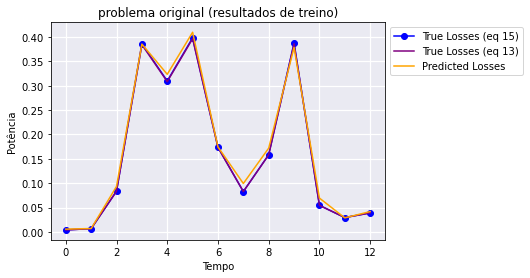

In [18]:
pred_Y=X@mean_best_beta

plot_predictions(Y1,Y2,pred_Y,'train','original')

### **Test DataSet**
    
Use Loss Function (Beta Coeficients), to compute the losses considering a new Power Consumption dataset (Ptest). 

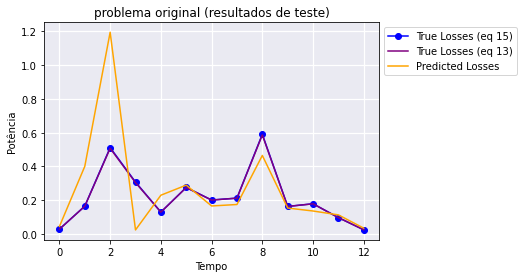

In [19]:
Xtest=create_X(Ptest)

pred_Ytest=Xtest@mean_best_beta

plot_predictions(Y1test,Y2test,pred_Ytest,'test','original')

# Challenges
Think about an interesting variation to this problem or a different way to solve and implement it !!!

Some ideas:
- Assume the grid is a LV grid and rewrite (16) assuming that angle differences are negligible (only voltage magnitudes differences are expressive). Assume that in LV grids, Bij << Gij.
- Replace the matrix X, in Equation 16, for:\n
    - i) a matrix X' considering the network structure (only use 2.Pi.Pj when a line connection exists). 
    - ii) reducing the dimensionality of X by considering squared injections (Page 33 in the lectures notes) 
    - iii) reducing the dimensionality of X by summing electrically close bus injections before using them as explanatory variables of losses (Page 33 in the lectures notes)
    - Compare with the proposed method in a larger network


### Challenge 1: 
- adjacency (i.e. neighbourhood of range $r\le1$)
- technically $r\le2$ would be fruitful as well, but only in a larger, more complex network

In [20]:
# training data
X1 = create_X(P)
# adapt matrix X to challenge 1
X1 = np.delete(X,[3,6],axis=1) # deleting columns 3 and 6, respectively corresponding to beta_14 and beta_24

iterations=1000
noise_proportion=1
best_beta1=find_mean_betas(X1,Y1,Y2,noise_proportion,iterations)[1]

pred_Y1=X1@best_beta1


# test data
X1test = create_X(Ptest)
# adapt matrix X to challenge 1
X1test = np.delete(Xtest,[3,6],axis=1) # deleting columns 3 and 6, respectively corresponding to beta_14 and beta_24

pred_Y1test=X1test@best_beta1

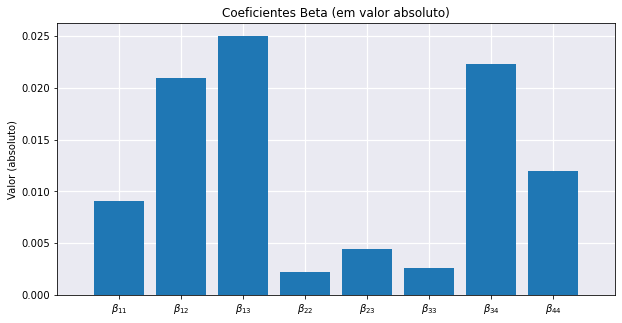

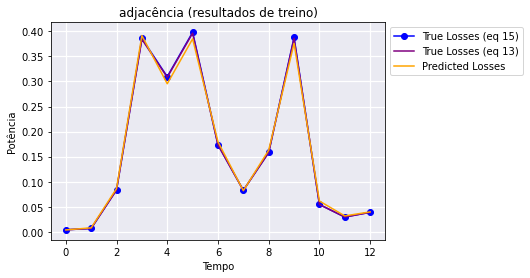

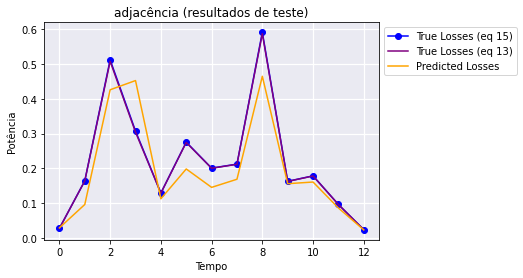

In [21]:
xAxisLegend=[r'$\beta_{11}$',r'$\beta_{12}$',r'$\beta_{13}$',r'$\beta_{22}$',r'$\beta_{23}$',r'$\beta_{33}$',r'$\beta_{34}$',r'$\beta_{44}$']
plot_beta(best_beta1,xAxisLegend)

plot_predictions(Y1,Y2,pred_Y1,'train','adjacency')
plot_predictions(Y1test,Y2test,pred_Y1test,'test','adjacency')


### Challenge 2: 

repeating the same experiment for a large amount (e.g. 1000) of times to average and thus flush out:
- beta explainability
- plots (i.e. prediction results)

Done before, among the code ()

### Challenge 3: 
$1^{st}$ from the notes
$ X = [ P_1^2 | P_2^2 | P_3^2 | P_4^2 ]$ ( a cada linha )

In [22]:
def create_X_chal_3(P):
    N=P.shape[1]
    X = np.zeros((time,N))
    for i in range(time):
        for j in range(N):
            X[i,j] = P[i,j]**2
    return X

# training data
X3 = create_X_chal_3(P)

iterations=1000
noise_proportion=1
best_beta3=find_mean_betas(X3,Y1,Y2,noise_proportion,iterations)[1]

pred_Y3=X3@best_beta3


# test data
Xtest3 = create_X_chal_3(Ptest)

pred_Ytest3=Xtest3@best_beta3

### Results:

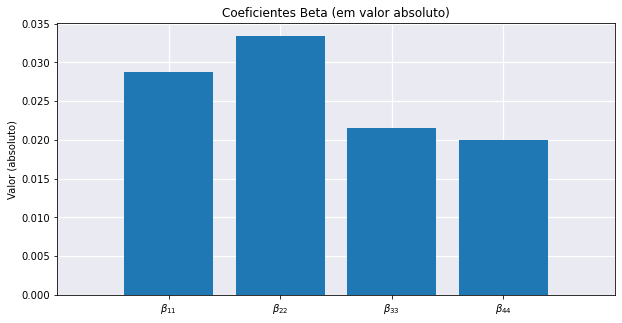

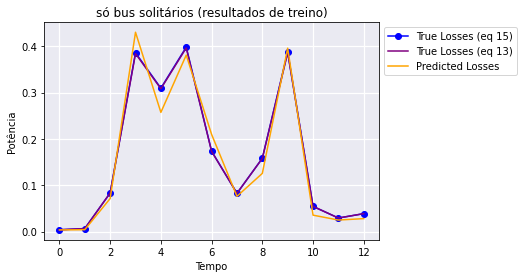

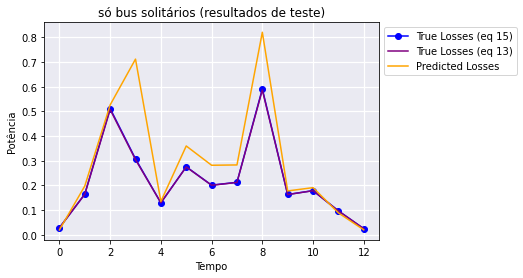

In [23]:
xAxisLegend = [r'$\beta_{11}$',r'$\beta_{22}$',r'$\beta_{33}$',r'$\beta_{44}$']

plot_beta(best_beta3, xAxisLegend)

plot_predictions(Y1,Y2,pred_Y3,'train','only accounting each bus')

plot_predictions(Y1test,Y2test,pred_Ytest3,'test','only accounting each bus')

### Challenge 4: 
$2^{nd}$ from the notes:
- (linha 1) $ X_{t_1} = [ P_\Sigma^2 | 2 P_\Sigma P_4 | P_4^2 ]$ for $t_1$
- ...
- (linha 2) $ X_{t_N} = [ P_\Sigma^2 | 2 P_\Sigma P_4 | P_4^2 ]$ for $t_N$

In [24]:
def create_X_chal_4(P):
    N=3
    P_sigma=P[:,0]+P[:,1]+P[:,2]
    X = np.zeros((time,N))
    for i in range(time):
        X[i,0]=P_sigma[i]**2
        X[i,1]=2*P_sigma[i]*P[i,-1]**2
        X[i,2]=P[i,-1]**2
    return X

# training data
X4 = create_X_chal_4(P)

iterations=1000
noise_proportion=1
best_beta4=find_mean_betas(X4,Y1,Y2,noise_proportion,iterations)[1]

pred_Y4=X4@best_beta4


# test data
Xtest4 = create_X_chal_4(Ptest)

pred_Ytest4=Xtest4@best_beta4

### Results:

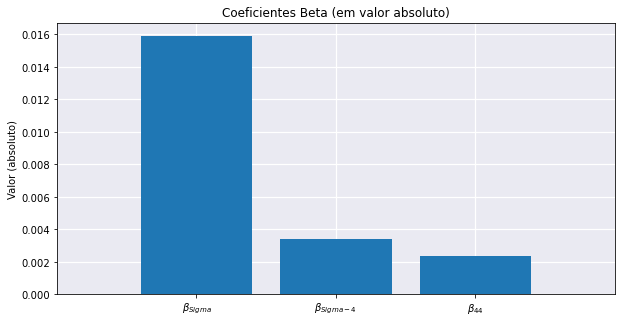

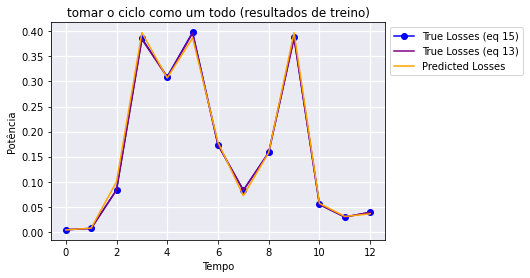

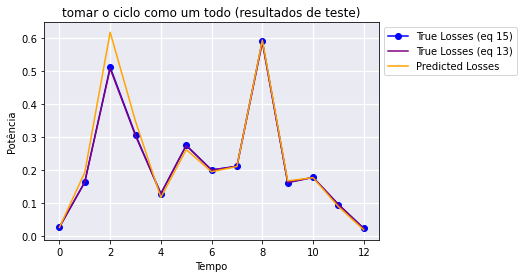

In [25]:
xAxisLegend = [r'$\beta_{Sigma}$',r'$\beta_{Sigma-4}$',r'$\beta_{44}$']

plot_beta(best_beta4, xAxisLegend)

plot_predictions(Y1,Y2,pred_Y4,'train','accounting cycle as a whole')

plot_predictions(Y1test,Y2test,pred_Ytest4,'test','accounting cycle as a whole')

## Final conclusion error plot:

In [26]:
def error(Y1,Y2,pred_Y):
    # average of P_L 
    Y=(Y1+Y2)/2
    return np.sqrt(np.mean((Y-pred_Y)**2))

In [27]:
#newline0=[error(Y1test,Y2test,pred_Ytest),error(Y1test,Y2test,pred_Y1test),error(Y1test,Y2test,pred_Ytest3),error(Y1test,Y2test,pred_Ytest4)]
#newline1=[error(Y1test,Y2test,pred_Ytest),error(Y1test,Y2test,pred_Y1test),error(Y1test,Y2test,pred_Ytest3),error(Y1test,Y2test,pred_Ytest4)]
#newline2=[error(Y1test,Y2test,pred_Ytest),error(Y1test,Y2test,pred_Y1test),error(Y1test,Y2test,pred_Ytest3),error(Y1test,Y2test,pred_Ytest4)]
#newline3=[error(Y1test,Y2test,pred_Ytest),error(Y1test,Y2test,pred_Y1test),error(Y1test,Y2test,pred_Ytest3),error(Y1test,Y2test,pred_Ytest4)]
#newline4=[error(Y1test,Y2test,pred_Ytest),error(Y1test,Y2test,pred_Y1test),error(Y1test,Y2test,pred_Ytest3),error(Y1test,Y2test,pred_Ytest4)]
newline5=[error(Y1test,Y2test,pred_Ytest),error(Y1test,Y2test,pred_Y1test),error(Y1test,Y2test,pred_Ytest3),error(Y1test,Y2test,pred_Ytest4)]

In [28]:
newline0=[0.01876881885407021,
 0.08692654975611201,
 0.1260903047048362,
 0.02996531355598041]

In [29]:
newline1=[0.014984466364602692,
 0.08011234408363795,
 0.12614699030456603,
 0.029675198721331335]

In [30]:
newline2=[0.017438925779364463,
 0.08144240139572498,
 0.12489503443499253,
 0.029591068752298097]

# erros por ordem: 0, 1/20, 1/10
# ficam a faltar, 

In [31]:
newline3=[0.010893818944989982,
 0.08806121775238679,
 0.12752938688262055,
 0.029281269913158443] # 1/5

In [32]:
newline4=[0.03336612860713018,
 0.0694235482944013,
 0.12894346084279987,
 0.030147692223309378] # 1/2.5

# fica a faltar 1

In [36]:
newline5=[0.2212428514393318,
 0.06788533927780031,
 0.13562597297420464,
 0.03356793078906709]

In [39]:
error_lines=np.array([newline0,newline1,newline2,newline3,newline4,newline5])

In [33]:
# values obtained by running the code for different noise_proportion values
# 0
line0=[0.01876881885407021,
    0.08692654975611201,
    0.1260903047048362,
    0.02996531355598041]
line0=np.array(line0)

# 1/10
line1=[0.014911690617935021,
    0.08763019920557225,
    0.12645672552857104,
    0.029857006326786582]
line1=np.array(line1)

# 1/2
line2=[0.023254652347848615,
    0.09058755372133594,
    0.1165201444320292,
    0.03210248500586112]
line2=np.array(line2)

# 1
line3=[0.05728685292583109,
    0.050347781847020885,
    0.13744115177231608,
    0.033131166890665205]
line3=np.array(line3)

# 5
line4=[0.299133209544148,
    0.22430569829946587,
    0.07671882447812457,
    0.03893162977432866]
line4=np.array(line4)

#error_lines=np.array([line0,line1,line2,line3,line4])



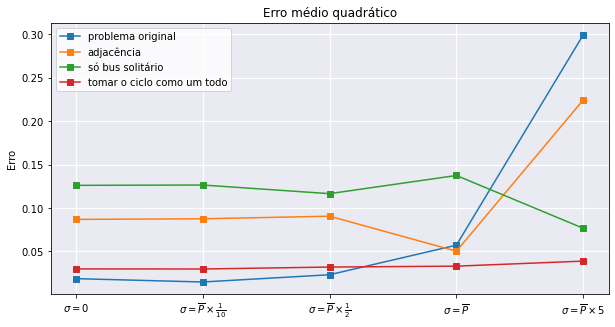

In [34]:
xAxisLegend=[r'$\sigma=0$',r'$\sigma=\overline{P}\times\frac{1}{10}$',r'$\sigma=\overline{P}\times\frac{1}{2}$',r'$\sigma=\overline{P}$',r'$\sigma=\overline{P}\times5$']


# same plot, but with label for each line
def plot_error(error_lines, xAxisLegend):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(xAxisLegend,error_lines[:,0],'s-',label='problema original')
    ax.plot(xAxisLegend,error_lines[:,1],'s-',label='adjacência')
    ax.plot(xAxisLegend,error_lines[:,2],'s-',label='só bus solitário')
    ax.plot(xAxisLegend,error_lines[:,3],'s-',label='tomar o ciclo como um todo')
    #ax.set_xlabel('Desvio padrão')
    ax.set_ylabel('Erro')
    ax.set_title('Erro médio quadrático')
    # set background color
    ax.set_facecolor('#eaeaf2')
    # add white grid
    ax.grid(color='white', linestyle='-', linewidth=1.25)
    # make the grid completely transparent when on top of the bars
    ax.set_axisbelow(True)
    ax.grid(visible=True, color='white', linestyle='-', linewidth=1.25)
    plt.legend()
    plt.show()

plot_error(error_lines,xAxisLegend)


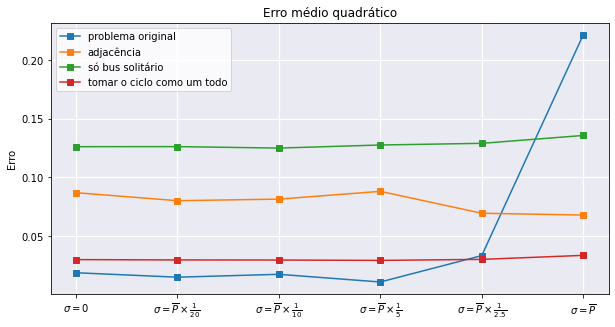

In [40]:
xAxisLegend=[r'$\sigma=0$',r'$\sigma=\overline{P}\times\frac{1}{20}$',r'$\sigma=\overline{P}\times\frac{1}{10}$',r'$\sigma=\overline{P}\times\frac{1}{5}$',r'$\sigma=\overline{P}\times\frac{1}{2.5}$',r'$\sigma=\overline{P}$']


# same plot, but with label for each line
def plot_error(error_lines, xAxisLegend):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(xAxisLegend,error_lines[:,0],'s-',label='problema original')
    ax.plot(xAxisLegend,error_lines[:,1],'s-',label='adjacência')
    ax.plot(xAxisLegend,error_lines[:,2],'s-',label='só bus solitário')
    ax.plot(xAxisLegend,error_lines[:,3],'s-',label='tomar o ciclo como um todo')
    #ax.set_xlabel('Desvio padrão')
    ax.set_ylabel('Erro')
    ax.set_title('Erro médio quadrático')
    # set background color
    ax.set_facecolor('#eaeaf2')
    # add white grid
    ax.grid(color='white', linestyle='-', linewidth=1.25)
    # make the grid completely transparent when on top of the bars
    ax.set_axisbelow(True)
    ax.grid(visible=True, color='white', linestyle='-', linewidth=1.25)
    plt.legend()
    plt.show()

plot_error(error_lines,xAxisLegend)
